# Application of Tfidf-vectorizer on wine data  (Still in progress!!!!)

*This study is the second prelude to a grape variety classifier based on semi-professional wine notes. We present a bag-of-words type analysis of data using term frequencies alone and inverse document frequency correction as well. We examine how applicable are these word vectorizers in order to differentiate between grape varieties.*

Analysing data and concepts is key to create a reliable classifier in machine learning. The style of the text input in our case can vary significantly, therefore it is unlikely that a classifier will do a perfect job. The analysis presented here helps to understand the deficiencies of the model and give us some hints, why was a wine description classified into one grape variety and not to the other. 

In the [first part](https://diveki.github.io/projects/wine/wine.html) of the blind taster analysis we used brute force to collect data, reduce noise and extract term frequency information on the wine descriptions. Also we detailed where had our data come from and what preprocessing had we used to prepare it to analysis. 

In this study we will use *scikit-learn*'s [count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [tf-idf vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to build a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) vector model and use their methods to derive numerical evidence on the similarity or dissimilarity of the grape varieties. 

In the [final study](https://diveki.github.io/projects/wine/sommelier.html) we incorporate these vectorizers into a classifier that will predict what grape was used to make a wine based on the wine's description.


In the begining of this study we review some **Natural Language Processing** (NLP) techniques and their meaning and then we apply those concept to our wine dataset and try to understand what are the similarities and differencies in the descriptions of the wines made from different grapes. Here we will cover the following topics:

1. [Bag-of-words concept](#ch1)
2. [Reviewing the previous Article (tokenization, filtering, pos tagging, comparing)](#ch2)
3. [Term frequency and the count vectorizer](#ch3)
4. [Inverse document frequency and the Tf-idf vectorizer](#ch4)
5. [Similarity study of documents belonging to one class](#ch5)
6. [Conclusion](#ch6)
7. [References](#ch7)

<a id='ch1'></a>
# 1. Bag-of-words concept

 The bag-of-words concept is a very simple approach to text analysis in NLP. In its basic form it relies on the decomposition of text into words. From the union of all words, let us say N words, from all documents, M documents, under investigetion it forms a vector (refered to as vocabulary). Each document can be represented as a vector of this vocabulary with a length of *N*, resulting in a matrix of size $M\times N$. The figure below shows a detailed demonstration of this concept (taken from [Quora discussion](https://www.quora.com/What-is-the-bag-of-words-algorithm)).

![Bag-of-words](https://qph.fs.quoracdn.net/main-qimg-4934f0958e121d33717f848230ef664a)

The obtained matrix is usually very sparse, since only a small portion of the vocabulary is expected to appear in each document. Often, people apply stopwords. These are usually filling words which are very frequent in all documents, but does not have any descriptive meaning, like *for, is, of the, etc.* When applying the bag-of-word concept we leave out the stopwords from the analysis. The bag-of-words concept does not take into account the order of the words, therefore the causality and references between words are lost. This can be somewhat improved if one introduces N-grams.

The figure above is a special case of N-grams, the 1-gram. The text is decomposed into individual words. In N-grams the text is decomposed into N consecutive term. For example, in the case of the above figure the first two 2-grams could be: *'quick brown', 'brown fox'* (note that we took into account the stopwords).

The bag-of-words concept is usually paired with a document classifier where the decomposed terms are features. There are several types of classifiers but we will discuss the term frequency and term frequency with inverse document frequency methods. 

Before discussing these classifiers we first quickly review the concepts applied in the [previous study](https://diveki.github.io/projects/wine/wine.html).

<a id='ch2'></a>
# 2. Reviewing the previous Article (tokenization, filtering, pos tagging, comparing)

Let us start by importing python modules that we will use in the analysis. 

In [1]:
%matplotlib inline
# packages and methods for data manipulation
import pandas as pd
import numpy as np
from functools import reduce

# packages and methods for text analysis
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

# function to split data into train and test samples
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt


Then we load the data that contains the scraped and pre-cleaned information about the wines. This data and the whole project can be found at my [github repository](https://github.com/diveki/WineSommelier). Feel free to take a copy of it and improve it. The data collection and processing is explained in the [previous study](https://diveki.github.io/projects/wine/wine.html). 

Just as before we are mainly interested in the *grape_variety* and *description* columns however real sommeliers can take a look at the colour of the wine, therefore the *colour* can be a featur too. 

In [2]:
filename = '../DataBase/5_grape_db.xlsx'

a0 = pd.read_excel(filename)
a0.head()

,abv,colour,country,description,grape_variety,name,Body
0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light
1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium
2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium
3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium
4,13.5,red,Argentina,this wine has concentrated aromas and flavours...,cabernet sauvignon,Argento Cabernet Sauvignon 2014,full


In our analysis we will constrain filter out all the grape varieties that occurs less than a predifined *limit* in our dataset.

In [3]:
result = a0['grape_variety']
limit = 40
## removing varieties that have only one member in the database
counts = nltk.Counter(result)
varieties = [key for key in counts if counts[key] > limit]
data_input = a0[a0['grape_variety'].isin(varieties)].reset_index()

We divide our dataset into train and test sets. 67% of the input will belong to the train and the rest to the test. 

In [4]:
# split the data into train and test
combined_features = ['description', 'grape_variety']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(data_input[combined_features], data_input[target], 
                                                    test_size=0.33, random_state=42)


The grape varieties in the train set are not equally represented. The white wines, the *chardonnay* and the *sauvignon blanc* have the most samples. Simply because of that feature we can already expect that some words will be more frequent in the white wine descriptions than in the red ones. 

Next we aggregate the wine descriptions by the grape variety. Therefore, we will have four documents (one for each grape) with long descriptions. 

In [5]:
# aggregate description by grape type
grouped = X_train[['grape_variety', 'description']].groupby(['grape_variety']).agg(
    {'description': lambda z: reduce(lambda x,y: ''.join(x+y), z)}
)
grouped.head()

,description
grape_variety,
chardonnay,' quest to create an australian rival to the t...
pinot noir,as seen on tv.the belen estate in chile 's cas...
sauvignon blanc,"this classic displays elements of gooseberry ,..."
syrah,are dedicated to showcasing the wide range of ...


Using this dataset, in the [previous study](https://diveki.github.io/projects/wine/wine.html) we applied the bag-of-words concept by aggregating the wine descriptions by grape varieties. We used the *nltk* package's *word_tokenize* method to obtain 1-gram terms. For each 1-gram we calculated their frequency within each grape variety. 

By visually inspecting these terms and the corresponding frequencies we saw that there are many useless filling words in the text, so we built up a filter, *stop_words*, that removed these terms. 

We have also observed that many of the terms appear in different forms, like in singular and plural form, while actually they should be counted together. *Lemmatization* is the process that brings the words into their common form. A lemmatizer to perform its job needs to know what type of word is it given as an input, a noun, verb, adjective etc. That is determined by the position tagger. We have applied position tagging and lemmatization to find the common form of the words, reducing the vocabulary and possible tightening the number of useful words in the documents. 

Finally, we compared the obtained vocabularies of grape varieties and search for the differences and similarities. We wanted to find out are there words that are characteristic for a certain grape type and appear more frequently for them. For that we calculated correlations and tried to explained the outcome. 

In the following sections we will basically repeat the same thing as in that study, but we will use classifiers like the *CountVectorizer* and *TfidfVectorizer*, to create vocabulary, count words and filter noise. These objects are highly adjustable and easy to use them in a supervised machine learning task. They can be trained to classify a text into a target class and they can predict in which class a new text would belong. This classification and prediction step will be done in the [following study](https://diveki.github.io/projects/wine/sommelier.html). 

Here we will use these classifiers to understand if there are differences or characteristic features between the grape descriptions. 

<a id='ch3'></a>
# 3. Term frequency and the count vectorizer

A simple and easy way to classify documents into topics is to decompose them into words and count their frequency of occurence. This number is basically the raw count form of term frequency. One assumes that if a word is more frequent in a topic than in another then that word is probably characteristic to that topic. There are other forms of term frequency depending on what weighing has been applied [1], like: boolean, logaritmic scaling etc. Also, one has to keep in mind that different documents can vary in length a lot that can influence the term frequency too.

In python, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is used to count the term frequency of a document. We will stick to the raw count form below. First we create a list of stopwords, that will be filtered out, from the union of the stopwords from *nltk* package and some additional words and characters that we know from experience that are not useful. Then we instantiate a *CountVectorizer* object. It will count 1-gram words. For a detailed description of the input arguments, check its description on the scikit-learn website. 

In [6]:
# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop_words1 = frozenset(stop_words + stop_append)

# CountVectorizer instantiation with stop words, setting to count words of 1-grams and do not filter words based on their frequency
count_vec = CountVectorizer(stop_words=stop_words1, analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

Now that we have the counter object we can apply it on the wine descriptions to create a vocabulary with word counts for all words. Let us assume that the length of the vocabulary is *K*. Using the transform method we can turn the four documents into a $4\times K$ sparse matrix. Each number in the columns correspond to the frequency of a word in that row. 

In [7]:
# fit the description of the 4 wines
count_train = count_vec.fit(grouped.loc[:,'description'])
# based on the fitted vocabulary transform the document into vector representation with counts
bag_of_words = count_vec.transform(grouped.loc[:,'description'])

In [8]:
# bag of words matrix with raw count term frequency
bag_of_words.toarray()

array([[3, 7, 2, ..., 3, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 1, ..., 4, 2, 2],
       [0, 2, 1, ..., 0, 0, 0]])

Basically in a couple of lines of code we obtained a lot of information about the documents we provided. Knowing to use these classifiers like *CountVectorizer* can save a lot of time when analysing and building a predictor model. In the [previous study](https://diveki.github.io/projects/wine/wine.html) it took much more coding to get to this point. Furthermore, these objects are easy to modify and adjust, as we will see, therefore if we want to add further filtering or conditions it is easy to do. 

Let us first visually expect what are the most frequent words per grape varieties. For that we create a few helping function.

In [9]:
def most_frequent_words(bow, vector, categ, out_col=('grape', 'token', 'count')):
    df = pd.DataFrame()
    voc = sorted(count_vec.vocabulary_)
    for ii, row in enumerate(bow.toarray()):
        tmp = pd.DataFrame(dict(zip(out_col, (categ[ii], voc, row))))
        df = pd.concat([df, tmp], axis=0)
    return df 

# plot the word count of each grape type
def barplot_wordcounts(df, types, m=2, n=2, limit=10):
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axarr = plt.subplots(m, n, figsize=(13, 7))
    plt.subplots_adjust(top=0.99, bottom=0.15, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)
    ii = 0
    for row in axarr:
        for col in row:
            if ii < len(types):
                col.set_title(types[ii])
                if types[ii] in ['chardonnay', 'sauvignon blanc']:
                    palette_def = 'BuGn_r'
                else:
                    palette_def = 'Reds_r'
                filt_cond = (df['rank'] <= limit) & (df['grape']==types[ii])
                sns.barplot(x='count', y='token', ci = None,
                    data=df[filt_cond].sort_values('count', ascending=False), 
                    ax = col,
                    palette=sns.color_palette(palette_def,limit+3))#("Blues_r",15))
                ii += 1
                sns.despine(left=True, bottom=True)
                col.set_ylabel('')

In [10]:
# transform the bag of words into a data frame
df_count = most_frequent_words(bag_of_words, count_vec, grouped.index)
# rank the counts
df_count['rank']=df_count.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
df_count.tail()

,grape,token,count,rank
2016,syrah,zealand,0,1282.0
2017,syrah,zest,0,1282.0
2018,syrah,zesty,0,1282.0
2019,syrah,zingy,0,1282.0
2020,syrah,zippy,0,1282.0


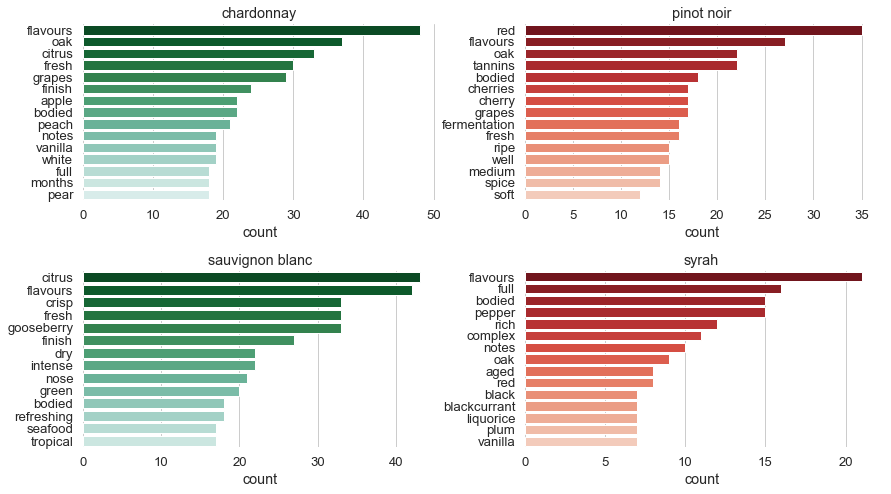

In [11]:
# plot the most frequent words
barplot_wordcounts(df_count, grouped.index, m=2, limit=15)

With these few lines of code we have already obtained some characteristic features of the different grapes. It is quite spectacular. Many of the tastes of wine, like *citrus, apple, gooseberry etc.*, do appear as most frequent words. As you can see many of the words appear in their plural form or ends on *-ed*. We can try to bring them into their basic form and reduce the number of items in the vocabulary. For that we need position tagging and lemmatization.

When sommeliers describing a wine they mostly use nouns and adjectives. These type of words give the most characteristics for the wine. In our next analysis we will filter anything besides nouns and adjectives. 

To perform these steps we define a few helper functions that decide if a word is a noun and create a lemmatizer object as well.

In [12]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc


Above we defined a *LemmaTokenizer* object that will help us to execute several things at once without writing a lot of code. This objects creates a *nltk WordNetLemmatizer* by instantiating it. The *CountVectorizer* object takes it as an argument and calles it. By calling the LemmaTokenizer it will perform the following steps on the input document:

1. defines a pattern that will filter out numbers, words with length smaller than 3 and all kinds of punctuations
2. splits the document into tokens (words)
3. filters out the patterns
4. gets rid of anything that has length = 1 (there can be still one characters because of the previous filtering)
5. performs position tagging
6. selects nouns and adjectives
7. generalizes the type of words into n or a
8. performs lemmatization.

You can have an additional step by uncommenting the last command. It will stem the words. This process is also trying to find common forms of the words.

Actually it is not obligatory to squeez in so many steps into this object, but as you can see, only with one class defined like this we can perform a lot of preprocessing on the document, before actually analysing or classiying the texts. 

Let us see what is the outcome of these steps.

In [13]:
count_vec = CountVectorizer(stop_words=stop_words1, analyzer='word', tokenizer=LemmaTokenizer(),
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [14]:
count_train = count_vec.fit(grouped.loc[:,'description'])
bag_of_words = count_vec.transform(grouped.loc[:,'description'])

Now we instatiate the *CountVectorizer* again with a new argument, called *tokenizer* and apply the *fit* method on it with the text input. Then as before we transform it into a bag-of-words form. Now let us plot again what are the most frequent numbers for the different grape types.

In [15]:
df_count = most_frequent_words(bag_of_words, count_vec, grouped.index)
df_count['rank']=df_count.groupby(['grape'], as_index=False)['count'].rank(ascending=False)

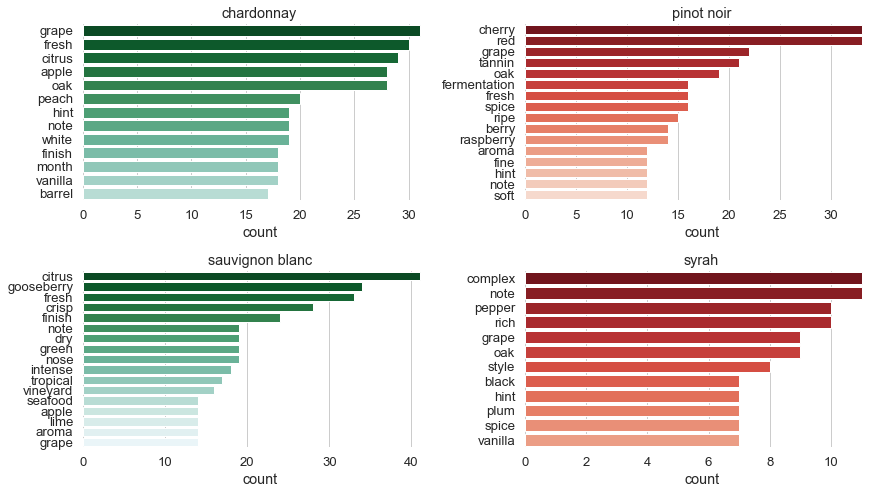

In [16]:
barplot_wordcounts(df_count, grouped.index, m=2, limit=15)

We managed to get rid of most of the plural nouns and increase the raw count of the corresponding singular words (see *cherry-cherries* at pinot noir). Also, there are basically no verbs and adverbs in the plot (the word *bodied* has disappeared from the figure). Besides these observations not much changed compared to the no lemmatizer version.

We can also see that there are several words that are very frequent within and accross the grape types, like *grape, note, etc.* These words are not helping us to distinguish between the grape varieties. Obviously, one could come up with additional noise filters, but in the next section we will present a different approach which tries to measure and weigh the importance of words within and accross documents.

To create a quantitative measure of how well does our *CountVectorizer* differentiate between the grape varieties we calculate the correlation between the vectorized representation of each document.

In [21]:
# transform the bag-of-words matrix into a data frame
a=pd.DataFrame(bag_of_words.toarray(), columns=sorted(count_vec.vocabulary_))
# take its transpose
a=a.T
# rename column names
a.columns=grouped.index

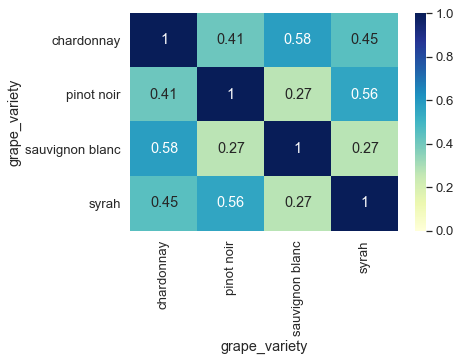

In [23]:
# calculate and plot correlation between grape types
a_count = a[a.columns].corr()
sns.heatmap(a_count, 
        xticklabels=a_count.columns,
        yticklabels=a_count.columns,
           annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

<a id="ch4"></a>
# 4. Inverse document frequency and the Tf-idf vectorizer


In [55]:
tfid_vec = TfidfVectorizer(stop_words=stop_words1, analyzer='word', tokenizer=LemmaTokenizer(),
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [56]:
tfidf_train = tfid_vec.fit(grouped.loc[:,'description'])
bag_of_words = tfid_vec.transform(grouped.loc[:,'description'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [57]:
df_tfidf = most_frequent_words(bag_of_words, tfid_vec, grouped.index)
df_tfidf['rank']=df_tfidf.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
df_tfidf.head()

,grape,token,count,rank
0,chardonnay,/mechanical,0.013083,369.5
1,chardonnay,ability,0.010315,530.0
2,chardonnay,able,0.000000,986.5
3,chardonnay,abundance,0.041258,72.5
4,chardonnay,acacia,0.020629,190.0


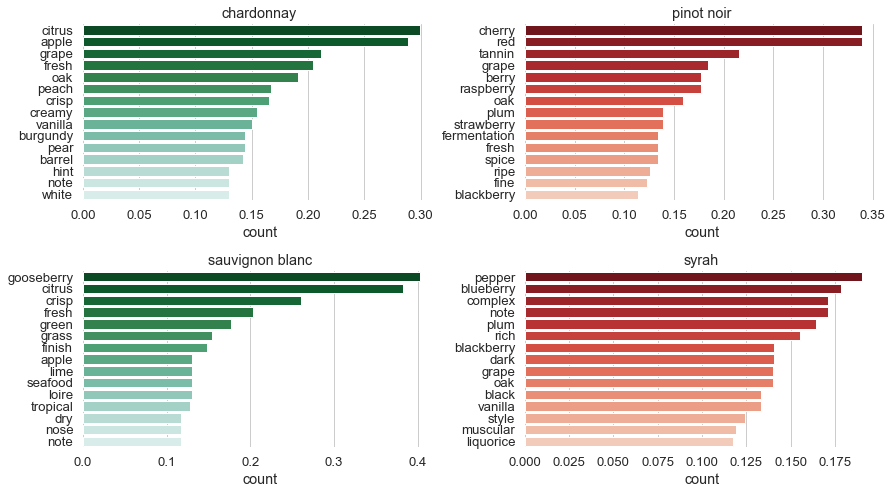

In [58]:
barplot_wordcounts(df_tfidf, grouped.index, m=2, limit=15)

In [59]:
tfid_vec.idf_.shape
word_idf = pd.DataFrame(
    {
        'token': list(sorted(tfid_vec.vocabulary_)), 
        'idf': tfid_vec.idf_}
)
word_idf.head()


,token,idf
0,/mechanical,1.916291
1,ability,1.510826
2,able,1.916291
3,abundance,1.510826
4,acacia,1.510826


In [60]:
word_idf['rank']=word_idf['idf'].rank(ascending=False)
idfs = pd.unique(word_idf['idf'].values)

In [61]:
print(word_idf[word_idf['idf']==idfs[0]].shape)
print(word_idf[word_idf['idf']==idfs[1]].shape)
print(word_idf[word_idf['idf']==idfs[2]].shape)
print(word_idf[word_idf['idf']==idfs[3]].shape)

(890, 3)
(258, 3)
(124, 3)
(74, 3)


In [62]:
ind=tfid_vec.vocabulary_.get('oak')
tfid_vec.idf_[ind]
word_idf[word_idf.token=='oak']

,token,idf,rank
834,oak,1.0,1309.5


In [66]:
a=pd.DataFrame(bag_of_words.toarray(), columns=sorted(tfid_vec.vocabulary_))
a=a.T
a.columns=grouped.index
atfidf = a.corr()
atfidf

grape_variety,chardonnay,pinot noir,sauvignon blanc,syrah
grape_variety,,,,
chardonnay,1.000000,0.238467,0.458316,0.245680
pinot noir,0.238467,1.000000,0.105151,0.424362
sauvignon blanc,0.458316,0.105151,1.000000,0.093611
syrah,0.245680,0.424362,0.093611,1.000000


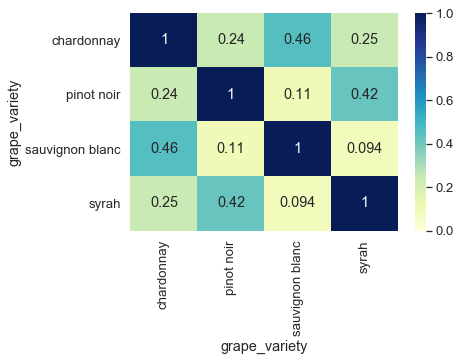

In [73]:
sns.heatmap(atfidf, 
        xticklabels=atfidf.columns,
        yticklabels=atfidf.columns,
           annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

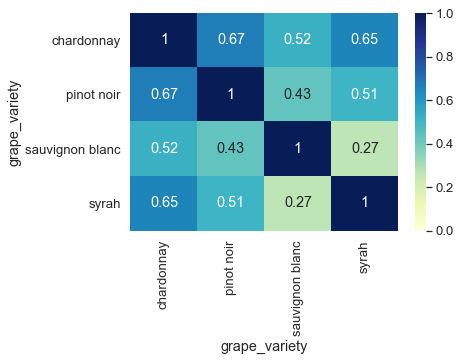

In [72]:
# common words to all of them
acommon = a[a.index.isin(list(word_idf[word_idf['idf']==idfs[3]]['token']))].corr()
sns.heatmap(acommon, 
        xticklabels=acommon.columns,
        yticklabels=acommon.columns,
           annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

# Analysis of document similarity within one grape variety


In [74]:
syrah = X_train[X_train.grape_variety == 'syrah']
syrah.head()

,description,grape_variety
210,are dedicated to showcasing the wide range of ...,syrah
69,this medium-bodied cote rotie is surprisingly ...,syrah
76,the explorateur wine offers sweet aromas of bl...,syrah
215,translates as lion 's den and is named after t...,syrah
234,full of robust and concentrated blackcurrant f...,syrah


In [75]:
tfidf_train = tfid_vec.fit(syrah.loc[:,'description'])
bag_of_words = tfid_vec.transform(syrah.loc[:,'description'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [76]:
voc = tfidf_train.vocabulary_
len(voc)

355

In [77]:
bag_of_words.shape

(27, 355)

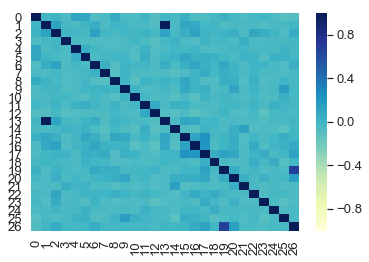

In [80]:
asyrah=pd.DataFrame(bag_of_words.toarray(), columns=sorted(voc))
asyrah=asyrah.T
#a.columns=grouped.index
acorr=asyrah.corr()
sns.heatmap(acorr, 
        xticklabels=acorr.columns,
        yticklabels=acorr.columns,
           cmap = 'YlGnBu', vmin=-1, vmax=1)

As we can see the most frequent 15 words are basically filling words or some kind of punctuations. Except for the word 'citrus' (sauvignon blanc) and 'red' (pinot noir) there are no other words in the plot that may give us a clue about the variety of the grape. Therefore it makes sense to filter the text from these filling words that make noise in the text and does not help to determine the variety of the grape. 

# 3. Filtering noise

In the first round we will apply a simple non alphabetic character remover to get rid of words with length of 1 and 2 characters, full stops, commas, numbers, etc. Then we apply a stopword filter from the nltk.stopwords package appended by some additional words that do not contain any usefool information about the variety of grapes like the word 'wine' and some more. These words appear above as some of the most frequent words to describe a wine.

In [11]:
# pattern for numbers | words of length=2 | punctuations | words of length=1
pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')

# remove tokens that are matching with the pattern
tkn_count['token'] = tkn_count['token'].apply(lambda t: pattern.sub('', t))
tkn_filt = tkn_count[-tkn_count['token'].isin([''])].reset_index()

# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavours', 'aromas', 'palate']
stop_words = stop_words + stop_append

# removing stopwords
tkn_filt1 = tkn_filt[-tkn_filt['token'].isin(stop_words)].reset_index()
tkn_filt1['rank'] = tkn_filt1.groupby(['grape'], as_index=True)['count'].rank(ascending=False)
tkn_filt1 = tkn_filt1.drop(['level_0', 'index'], axis=1)

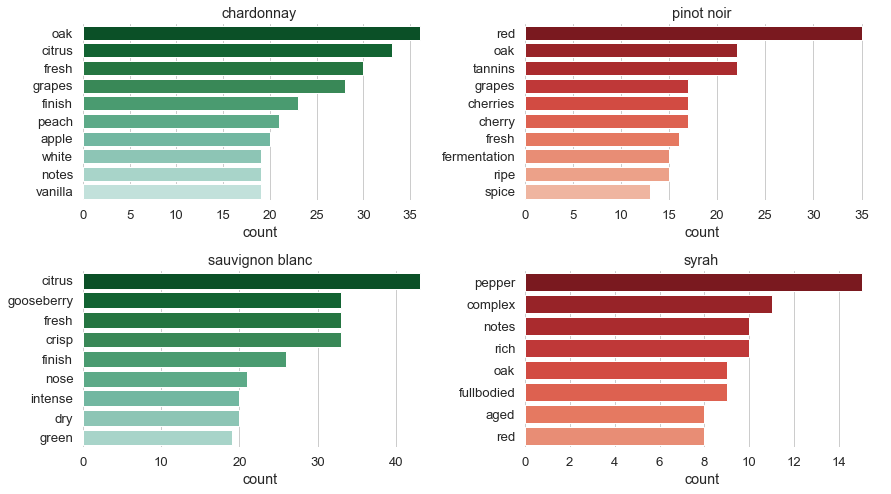

In [12]:
barplot_wordcounts(tkn_filt1, grouped.index, m=2)

After filtering, some of the taste and smell characteristics start to apppear in the most frequent words. These words differentiate the varieties. There are still some words that do not bear any information about the difference between the grapes, but for the moment we leave them in.

# 4. Part of Speech (POS) tagging and Lemmatization

The filtering step allows us to remove some basic noise from the collection of words but the remaining collection of words is still not clean enough. Particularly, some words may appear in different forms while actually having the same meaning. For example, in the case of pinot noir we can see the words cherry and cherries. They are the same but the former is singular noun while the latter is plural noun. To resolve this phenomena we can apply lemmatization. This process tries to group words into their common form. For that we use the *WordNetLemmatizer* from *nltk*. As an input it takes a string that tells the lemmatizer if the second argument, the token is a noun, verb, adjective or adverb. Therefore, first we write a few helper function that will help us to make this decision. 

First we prepare the tokens to be able to lemmatize. We apply *nltk*'s **part of speech (POS)** tagger [2]. This is one of the most important steps of NLPs. POS tagging will decide to which word class (noun, verb, etc.) a token belongs to based on a relationship to adjacent and related words. The POS tagger requires a list of tokens as an input and creates a list as an output with elements of tuples, where the first item is the token and the second is a tag (e.g. *VB* referring to verb).  

In [13]:
# helper functions to transform tags into nltk nouns, verbs, adjectives and adverbs
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    

In [14]:
lemm = WordNetLemmatizer           # creating a lemmatizer instance
ptags = nltk.pos_tag(tkn_filt1['token'].tolist())      # getting the pos tags for each token
ptags_wn = [(t[0], penn_to_wn(t[1])) for t in ptags]   # transforming pos tags into nouns, verbs, adj and adv
lems = [lemm.lemmatize(tag[1], tag[0]) for tag in ptags_wn]   # retrieving the common meaning roots
tkn_filt1['token'] = lems

After finding the lemmas we reduced the number of individual verbs present in the tokens, like there are no *cherries* in the *pinot noir*, they have been turned into cherry, increasing the number of its counts. Some of the characteristics of each grape variety starts to appear, like an aged chardonnay is kept in an *oak barrel* and bears *citrus* like tastes. *Pinot* has often *cherry, spicy, raspberry* falvors that do appear in its most frequented words.

In [15]:
tkn_filt1 = tkn_filt1.groupby(['grape', 'token'], as_index=False)['count'].sum()


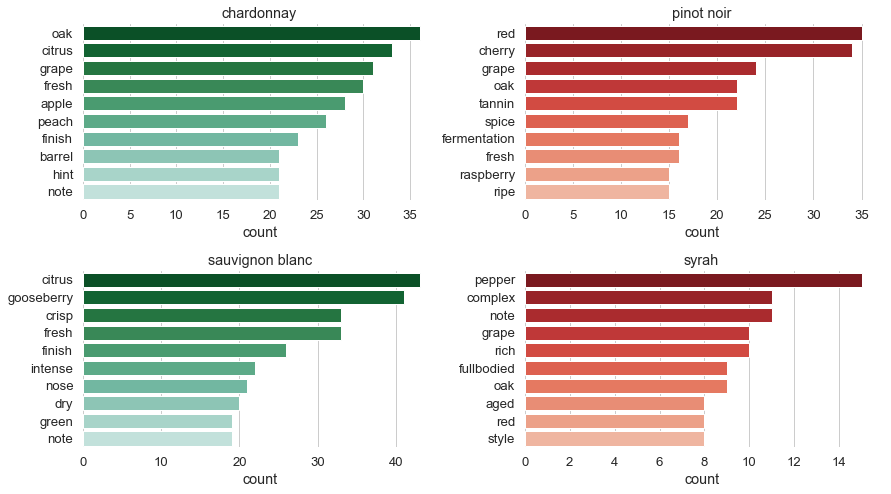

In [16]:
tkn_filt1['rank'] = tkn_filt1.groupby(['grape'], as_index=True)['count'].rank(ascending=False)
barplot_wordcounts(tkn_filt1, grouped.index, m=2)

However there are still many words that do not give any hint about which grape variety was used for a wine. The words *grape, note, style* etc. does not add any feature to the description of the grape. One way to solve this problem would be to look up manually all these words and filter them out, but on one hand this would be very tedious job and on the other we could expect that our model becomes overfitted. 

Instead a better approach would be a kind of entity chunking [3,4]. This is a complex procedure where based on linguistic knowledge one tries to extract information from the text. For example, one could build a model that finds the features in the text that belong to different predifined categories, like taste, palate, acidity etc. For now, we will not implement this technique.

Let us now investigate what are the common and disjoint words for these grapes. 

# 5. Comparison
To identify what makes our different grape varieties unique in terms of description of the wine we decompose our tokens into common words to all grape types and disjoint words, which can be only found in one of the grape descriptions. 
## Common words
As we could see from the plot of most frequent words per grape varieties there are overlap between the grapes. Finding common words can be a way of finding words that are not giving much information about the individual grape types. Although, we have to keep in mind 2 things: a) usually they are not equally distributed between the grapes, b) being a common word to all grapes does not directly mean that it has no feature behavoir to one of the grapes. We will see examples for the latter case later. Also note, that analysing the common words neglects all the words that are not found in the description of all of the grape types. After finding the common words we take a look at the correlation of their frequency between the grape types.

In [17]:
# changing name of columns to help finding the common words
dfs = []
for gr in varieties:
    tmp = tkn_filt1[tkn_filt1.grape == gr]
    tmp = tmp.add_suffix('_'+gr)
    tmp.columns=tmp.columns=tmp.columns.str.replace('token_'+gr,'token')
    dfs.append(tmp)
    
# merge each grape variety with each other on tokens
df_final = reduce(lambda left,right: pd.merge(left,right,on='token', how='outer'), dfs)

In [18]:
# by removing NAs from the dataframe we get the common words
df_common = df_final.dropna()
cols = df_common.columns.str.contains('count') | df_common.columns.str.contains('token')
df_common = df_common[df_common.columns[cols]]
df_common.corr()      # calculate the correlation

,count_pinot noir,count_sauvignon blanc,count_chardonnay,count_syrah
count_pinot noir,1.000000,0.449791,0.714380,0.465864
count_sauvignon blanc,0.449791,1.000000,0.560165,0.296221
count_chardonnay,0.714380,0.560165,1.000000,0.629290
count_syrah,0.465864,0.296221,0.629290,1.000000


The idea behind the correlation of common words is the following. If the frequency of a word is roughly the same for each grape type it means that word is probably just a filling word, not giving much information of any of the grapes. This scenario increases the correlation. If the frequencies are different, especially if it is very large for one of the grapes and small for the others that means, that word is probably a feature of one of the grapes and this would decrease the overall correlation. This whole argument is based on the assumption that each grape has the same amount of description sample with roughly the same number of tokens in it. But we know that this assumption is not true. 

Chardonnay has the largest sample size and the most tokens, it is understandable that it has large correlation with the other grape types. Chardonnay and Pinot Noir are used together to make champagne, in France both of them are usually oaked and also usually cultivated in the same wine region with similar teroir [5], therefor the correlation increases between them. Chardonnay is usually medium to full budied and has different tastes and flavors than Sauvignon Blanc which is often light budied and gives a feeling of freshness [6]. This might explain the lower level of correlation between them. Chardonnay and Syrah are both called big wines with deeper colors that is why Syrah is more correlated to Chardonnay than to Pinot Noir, which is lighter in color and easy to drink wine [7]. 

The correlation table also highlights that when comparing wines with each other it is not a simple categorization of red and white. Some reds have more similarities to whites. The color difference is mostly (but not entirely) due to the wine making process [8]. After the white grape is harvested the skin is separated from the juice while for red grapes usually the juice and the skin is sent to fermantation together. 

Let us now look at which words are the most frequent for all the grape types between all the common words. We cannot simply just add up the number of occurences of a word for each grape because the range of the occurances between grapes are not on the same scale, due to the fact that the sample sizes of the grape descriptions are different. Therefore, first we normalize the counts of word occurences within each grape variety using the *MinMaxScaler* of *sklearn* that outputs numbers between 0 and 1. One could use other scalers (like the normal scaler) but this one does not assume a distribution of samples, plus the outputs are non negative numbers helping us to do further analysis. Then we add up the normalized values (represented by the freq column) and sort them to see which words are the most frequent ones.

In [19]:
# perform normalization of counts using the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = df_common.copy()
sort_col = df_norm.columns.str.contains('count')
df_norm[df_norm.columns[sort_col]] = scaler.fit_transform(df_norm[df_norm.columns[sort_col]])
df_norm['freq'] = df_norm[df_norm.columns[sort_col]].sum(axis=1)

ind = df_norm['freq'].sort_values(ascending=False).index
df_norm.loc[ind[:10], ]  # visualize the 10 most frequent word within grape verieties

,token,count_pinot noir,count_sauvignon blanc,count_chardonnay,count_syrah,freq
298,grape,1.000000,0.40625,0.857143,0.9,3.163393
453,oak,0.913043,0.12500,1.000000,0.8,2.838043
277,fresh,0.652174,1.00000,0.828571,0.3,2.780745
450,note,0.478261,0.56250,0.571429,1.0,2.612189
255,finish,0.347826,0.78125,0.628571,0.5,2.257648
318,hint,0.478261,0.37500,0.571429,0.6,2.024689
562,ripe,0.608696,0.31250,0.400000,0.4,1.721196
386,made,0.304348,0.46875,0.342857,0.5,1.615955
449,nose,0.347826,0.62500,0.228571,0.4,1.601398
141,complex,0.217391,0.03125,0.285714,1.0,1.534356


Not surprisingly the word *grape* is the most common between all grape types. In the first ten occurances there are words like *note*, *grape* and *made* which are probably just noise words not giving any additional information about the grape types. 

But by carefully looking at the scores, we can see that for example the word *oak* is important for the Pinot Noir, Chardonnay and Syrah, but not for the Sauvignon Blanc. Also the word *complex* is rather characteristic for Syrah but not much for Pinot Noir and Chardonnay and especially not for Sauvignon Blanc. 

Let us visualize the importance of each common word within the grape types. We will calculate what is the proportion of a word used in a grape compared to the other grapes. 

Text(0,0.5,'token')

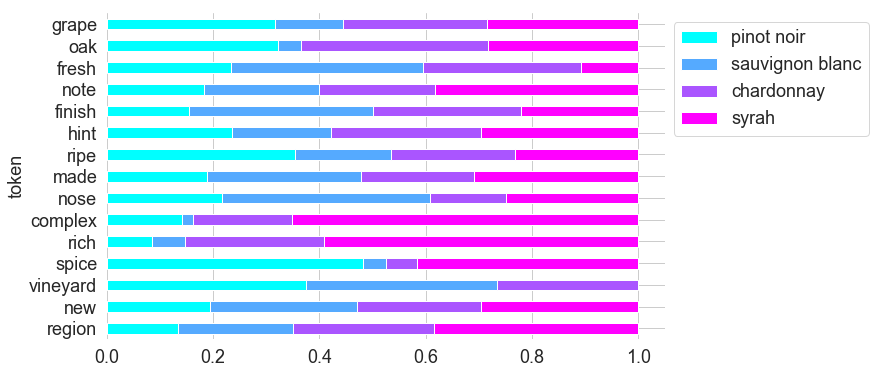

In [20]:
# preparing the stacked barplot
from matplotlib import cm
import matplotlib
cmap = cm.get_cmap('cool')
fsize = 18

dfplot = df_norm.sort_values(by='freq',ascending=False)
dfplot.index = dfplot['token']
sort_col = dfplot.columns.str.contains('count')
dfplot['csum'] = dfplot[dfplot.columns[sort_col]].sum(axis=1)
sort_col = dfplot.columns[dfplot.columns.str.contains('count')]

# creating the proportion columns
llabel = []
for col in sort_col:
    llabel.append(col.replace('count_',''))
    dfplot[col] = dfplot[col] / dfplot['csum']

# plotting
ax = dfplot.loc[list(reversed(dfplot.index[:15])), sort_col].plot(kind='barh', stacked=True, cmap=cmap, 
                                                                  figsize=(10, 6), fontsize=fsize)
ax.legend(llabel, bbox_to_anchor=(1., 1), fontsize=fsize)
ax.set_facecolor('w')
ax.set_frame_on(False)
ax.set_ylabel(ax.get_ylabel(), fontsize=fsize)

In the above figure we plot 15 most frequent words with the most frequent one being at the top. The words like *finish, hint, made* and *new* are roughly equally important for each wine. These words will not add information about the grape variety. However, the words *oak, rich, spice* and *complex* has negligible meaning for the Sauvignon Blanc, while the word *complex* seems to be really descriptive for the Syrah. *Spice* is important for the Pinot Noir and Syrah and less important for the two white grapes. This means that when training a predicting model this word can be confusing and may contribute to the mixing up of these to grapes when predicting their grape type. 

## Disjoint words

Now we turn to the words that are unique to each grape type. We expect to find some very characteristic features that may be unique for the grape type in question. 

In [21]:
# define a new dataframe container for the unique words
df_unique = pd.DataFrame()
for gr in varieties:
    cond = ~(df_final.columns.str.contains(gr) | df_final.columns.str.contains('token'))
    ind = df_final[df_final.columns[cond]].isna().all(1)  # find unique words in each column
    tmp = df_final.loc[ind, ~cond]
    tmp.columns = tmp.columns.str.replace('_'+gr, '')
    df_unique = pd.concat([df_unique, tmp], ignore_index=True, sort = True)

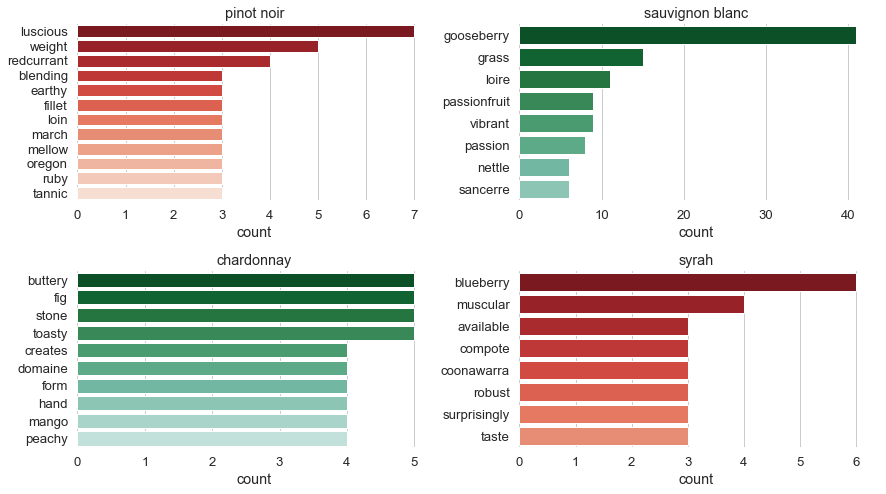

In [22]:
# rank and sort the words and then plot the outcome
df_unique['rank'] = df_unique.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
barplot_wordcounts(df_unique, varieties, m=2)

Finally, we can see some true grape characteristics. However we have to keep in mind that these words are not necesarrily the best describers. It can happen that the best feature of a grape also appears (maybe rarely) in another one and our procedure has filtered it out, since we are showing only the common and disjoint (but not partially disjoint) features. 

Buttery aromas and toasty flavors are indeed characteristic to Chardonnay [9]. Look at Sauvignon Blanc's *gooseberry* count. That taste is indeed very frequent to that grape [10]. Just as *grass* and *passion fruit*. 

We also find a few words like *hand, creates, available, surprisingly* etc. that are not really grape dependent. These will also add some noise to the analysis. 

From these words we can actually see that the most relevent type of words that describe important characteristics about the grapes are nouns and adjectives. Verbs usually describe action and not features of a grape. Let us see, how many nouns, adverb, adjectives and verbs are in these unique words.

In [23]:
# finding POS tags
df_unique['pos'] = df_unique.apply(lambda row: penn_to_wn(nltk.pos_tag([row['token']])[0][1]), axis=1)
df_unique.groupby([ 'pos']).count()[['count']]

,count
pos,
a,101
n,848
r,89
v,200


Indeed, nouns are far more numerous than any other category. Nouns and adjectives together give more than two thirds of the words. We could replot the most important words after filtering for nouns and adjectives, but the outcome would be the same. This is a bit surprising since the word *creates* is probably a verb but it was tagged to be a noun. This shows the weakness of a simple POS tagging. This gives room for improvement on this project.

# 6. Conclusion
In this report we presented a simple Natural Language Processing approach based on word analysis to derive characteristic features of grape varieties from semi-professional wine descriptions. 

It was possible to show that although the descriptions were not well structured and contained a lot of irrelevant information with respect to the grape varieties we could extract grape characteristic nouns and adjectives. We showed that there are many common words used for each grape variety, but one can also find important words that belong to only one grape. These findings help to understand the background of the decisions made by a grape variety forecaster. Such kind of forecaster will be presented in the [next report](https://diveki.github.io/projects/sommelier.html). 

Since this analysis is based on a simplistic approach there is plenty of rooms for improvement:
- Collecting much more data and preferably less noisy data from professional wine experts.
- Write better noise filters that may remove words that do not contain important information about the grape.
- Improve POS tagging to find the right tags .
- Improve lemmatization, since there were many words not identified as the same token while having slightly different forms.
- One could apply stemming too.
- Write a complex code for information extraction into categories like taste, aroma, flavor, palatte, body etc. Finding words into these predefind categories could boost the performance of an algorithmic sommelier by a lot. 

Finally we showed that **using methodical analysis, algorithms can help people to become excellent sommeliers.**

If you have any questions, observations or suggestions please contact me at [diveki@gmail.com](diveki@gmail.com). You can also fork this project from [my GitHub repository](https://github.com/diveki/WineSommelier) or you can take a sneaky look at [my GitHub Pages website](https://diveki.github.io). 



# 7. Appendix: Getting the data
## Scraping
We were using the *Bibendum* and *Majestic Wine* websites to extract relevant information. You can find the two python codes [here](https://github.com/diveki/WineSommelier/tree/master/Scraping). Unfortunately, there is a great chance that the *webScraping.py* code will fail since Bibendum has re-structered its website after we have completed the scraping code.

The codes heavily rely on the *requests, Beautiful Soup* and *re* python packeges. The code loops through each page on the website that contains the list of wines and saves down their name and the link they point to into a wine class. The wine class is initialized by the name of the wine and its link. This class has methods to retrieve the description text about the wine and any other interesting detail about the wine, like name of producer, country, alcohol level, grape variety, body etc. Unfortunately these additional information are not present in all wines. Therefore we step through on each of them and fill the missing information with NAs. Finally the data is saved to the disk in .xlsx format. The combined data from Bibendum and Majestic Wine (at July 2018) builds upt to a total of 2366 items. 

## Data cleaning
- We take any text based input and turn it into lower case characters and removed any accents to make everything uniform. 
- In some cases the body was not defined separately but mentioned in the text. We wrote a function that tries to extract that information if it is missing.
- If grape name was not given separately we tried to retrieve it from the wine name with a function.
- There are mispelled grape names and different grape names referring to the same grape in the raw text. In different countries the same grape is called differently. To make a collection of uniform names we tried to identify these issues and correct them.
- Removed % from alcohol level
- Sometimes in the description they mentioned the name of the actual grape, we replaced these instances with the word grape.
- Sometimes the color of the wine is mentioned in the description, we removed those colors.

We tried to pay attention to leave as less hints about the grape in the description as possible. That required removing words from the text and sometimes leaving behind sentences that feel strange for a human being. 

Unfortunately, from the 2366 items only a small portion can be used for machine learning purposes becuase many of those grapes are mentioned only a few times or once. That is why this work is restricted only to 4 single grape variety. We left out blends intentionally. 

The database that we publish with this work contains 5 major grape types: Chardonnay, Sauvignon Blanc, Pinot Noir, Syrah (Shiraz) and Cabernet Sauvignon. These belong to the most famous and favorite grape types in the world. If you go to a wine shop to get a bottle the chance that you choose one of these is really big. 




<a id="#ch7"></a>
# 7. References
1. https://en.wikipedia.org/wiki/Tf%E2%80%93idf